In this notebook, we take a 2D slice of the Compass model (representative for the Earth subsurface at North Sea) and simulate the CO2 dynamics.

First, we load the Julia packages.

In [1]:
using SlimPlotting, JLD2, PyPlot;
using Seis4CCS, Polynomials;

┌ Info: Precompiling Seis4CCS [808f26ee-2243-4b28-9f59-2530de529097]
└ @ Base loading.jl:1423
┌ Warning: Package Seis4CCS does not have JOLI in its dependencies:
│ - If you have Seis4CCS checked out for development and have
│   added JOLI as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Seis4CCS
└ Loading JOLI into Seis4CCS from project dependency, future warnings for Seis4CCS are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Cannot load /Users/francisyin/.julia/packages/ADCME/94vEM/deps/CustomOps/build/libadcme.dylib. Please recompile the shared library by `ADCME.precompile()` for using custom operators.
└ @ ADCME ~/.julia/pa

We download the data from dropbox and load it by JLD2

In [4]:
# run(`wget https://www.dropbox.com/s/tksm9e2w4opj9ib/Compass2km.jld2`);
JLD2.@load "Compass2km.jld2"

5-element Vector{Symbol}:
 :n
 :d
 :o
 :v
 :rho

Here, `n` denotes the dimension of the model, `d` the grid spacing, `o` the origin, `v` the acoustic velocity for each grid in km/s. We can take a look at the velocity by `plot_velocity` function in SlimPlotting package.

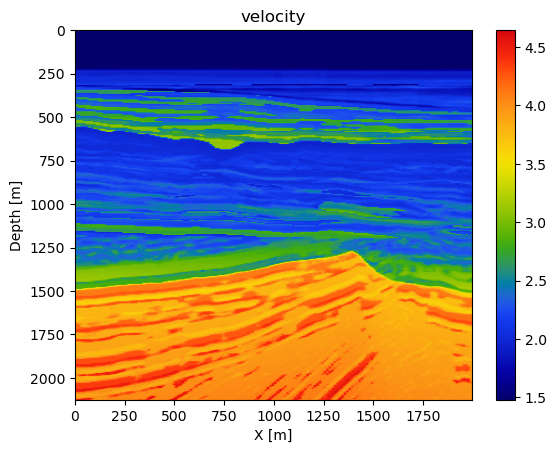

In [5]:
plot_velocity(v', d; name="velocity");colorbar();

To make a proxy permeability model representative for the North Sea area, we follow the Strategic UK CCS Storage Appraisal Project report and divide the whole model into multiple regions:

On the bottom is the main reservoir location, made of high permeable sandstones (>$200$mD)

The $50$m-depth primary seal lays over the reservoir, made of low permeable Rot Halite member ($10^3$mD)

A secondary seal is above the primary seal, made of relatively low permeable Haisborough group ($15-20$mD)

In each region, we assume a linear relationship between compressional wavespeed and permeability, indicated by the following article, where an increase of $1$km/s in velocity corresponds to an increase of $1.03$mD in permeability.

Klimentos, Theodoros. "The effects of porosity-permeability-clay content on the velocity of compressional waves." Geophysics 56.12 (1991): 1930-1939.

This velocity-to-permeability translation can be done via the following function.

In [32]:
function VtoK(v::Matrix{T}, d::Tuple{T, T}; α=1.03f0) where T

    n = size(v)
    idx_wb = find_water_bottom(v.-minimum(v))
    idx_ucfmt = find_water_bottom((v.-3.5f0).*(v.>3.5f0))
    Kh = zeros(Float32, n)
    capgrid = Int(round(50f0/d[2]))
    for i = 1:n[1]
        Kh[i,1:idx_wb[i]-1] .= 1f-10  # water layer
        Kh[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1] .= α*v[i,idx_wb[i]:idx_ucfmt[i]-capgrid-1].+15f0  # secondary seal
        Kh[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] .= 1f-3   # seal
        Kh[i,idx_ucfmt[i]:end] .= α*v[i,idx_ucfmt[i]:end].+200f0    # reservoir
    end
    return Kh
end;

Then following the Kozeny-Carman relationship, we can translate the permeability to porosity via the following function

In [33]:
function Ktoϕ(K::Matrix{T}, d::Tuple{T, T}) where T

    n = size(K)
    idx_ucfmt = find_water_bottom((K.-1f-3).*((K.==1f-3).|(K.>200f0)))
    capgrid = Int(round(50f0/d[2]))
    phi = zeros(Float32,n)
    for i = 1:n[1]
        for j = 1:n[2]
            p = Polynomial([-0.0314^2*K[i,j],2*0.0314^2*K[i,j],-0.0314^2*K[i,j],1.527^2])
            phi[i,j] = minimum(real(roots(p)[findall(real(roots(p)).== roots(p))]))
        end
        phi[i,idx_ucfmt[i]-capgrid:idx_ucfmt[i]-1] = Float32.(range(0.056,stop=0.1,length=8)) # porosity gradually decreases at the seal
    end
    return phi
end;

In [34]:
K = VtoK(v, d);
ϕ = Ktoϕ(K, d);

We can again plot the permeability and porosity via `plot_velocity` function

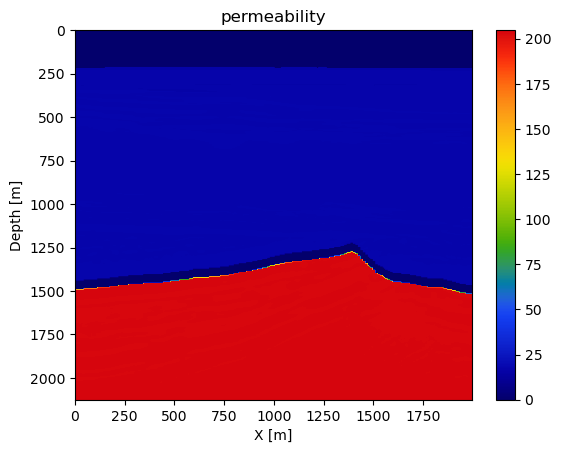

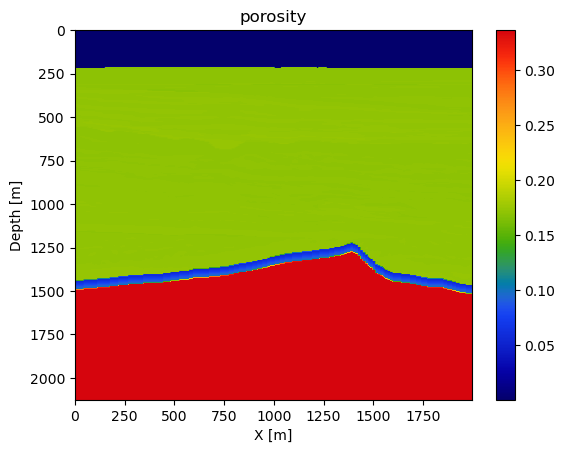

In [35]:
plot_velocity(K', d; name="permeability");colorbar();
plot_velocity(ϕ', d; name="porosity");colorbar();

We can further plot them more clearly to see the structures in each layer

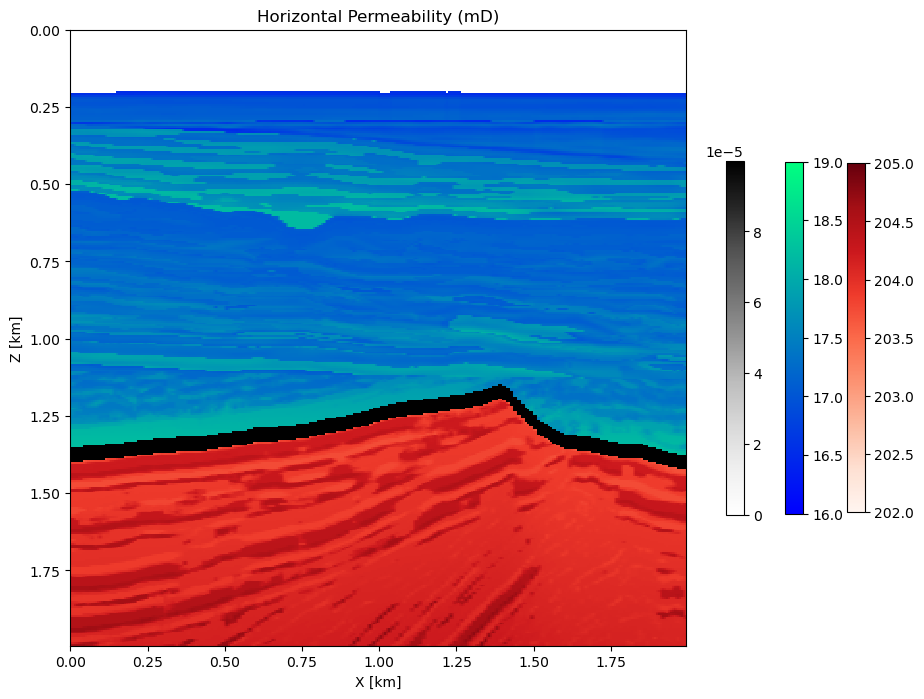

PyObject Text(0.5, 1.0, 'Horizontal Permeability (mD)')

In [30]:
using PyCall
@pyimport numpy.ma as ma
p1 = pycall(ma.masked_greater, Any, K', 50)
p2 = pycall(ma.masked_less, Any, K', 50)
p3 = pycall(ma.masked_greater, Any, K', 10)

extentx = (n[1]-1)*d[1]
extentz = (n[1]-1)*d[1]

fig,ax = PyPlot.subplots(figsize=(15,8))
pic2 = ax.imshow(p2,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Reds",vmin=202,vmax=205)
cb2 = colorbar(pic2,fraction=0.015, pad=0.038);
pic1 = ax.imshow(p1,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="winter",vmin=16,vmax=19);
cb1 = colorbar(pic1,fraction=0.016, pad=0.038);
pic3 = ax.imshow(p3,extent=(0,extentx/1f3,extentz/1f3,0),interpolation="None",cmap="Greys",vmin=0f0,vmax=1f-4)
cb3 = colorbar(pic3,fraction=0.017, pad=0.038);
xlabel("X [km]");ylabel("Z [km]");
title("Permeability (mD)")

The permeability and porosity will serve as the input for a reservoir simulator, which generates time evolution of CO2 plume.
    
We first set up the metadata for reservoir simulation.

In [9]:
const K_CONST =  9.869232667160130e-16 * 86400 * 1e3
const ALPHA = 1.0
const SRC_CONST = 86400.0 #
const GRAV_CONST = 9.8    # gravity constant

mutable struct Ctx
  m; n; h; NT; Δt; Z; X; ρw; ρo;
  μw; μo; K; g; ϕ; qw; qo; sw0
end

function tfCtxGen(m,n,h,NT,Δt,Z,X,ρw,ρo,μw,μo,K,g,ϕ,qw,qo,sw0,ifTrue)
  tf_h = constant(h)
  # tf_NT = constant(NT)
  tf_Δt = constant(Δt)
  tf_Z = constant(Z)
  tf_X= constant(X)
  tf_ρw = constant(ρw)
  tf_ρo = constant(ρo)
  tf_μw = constant(μw)
  tf_μo = constant(μo)
  # tf_K = isa(K,Array) ? Variable(K) : K
  if ifTrue
    tf_K = constant(K)
  else
    tf_K = Variable(K)
  end
  tf_g = constant(g)
  # tf_ϕ = Variable(ϕ)
  tf_ϕ = constant(ϕ)
  tf_qw = constant(qw)
  tf_qo = constant(qo)
  tf_sw0 = constant(sw0)
  return Ctx(m,n,tf_h,NT,tf_Δt,tf_Z,tf_X,tf_ρw,tf_ρo,tf_μw,tf_μo,tf_K,tf_g,tf_ϕ,tf_qw,tf_qo,tf_sw0)
end

function Krw(Sw)
    return Sw ^ 1.5
end

function Kro(So)
    return So ^1.5
end

function ave_normal(quantity, m, n)
    aa = sum(quantity)
    return aa/(m*n)
end

# variables : sw, u, v, p
# (time dependent) parameters: qw, qo, ϕ
function onestep(sw, p, m, n, h, Δt, Z, ρw, ρo, μw, μo, K, g, ϕ, qw, qo)
    # step 1: update p
    # λw = Krw(sw)/μw
    # λo = Kro(1-sw)/μo
    λw = sw.*sw/μw
    λo = (1-sw).*(1-sw)/μo
    λ = λw + λo
    q = qw + qo + λw/(λo+1e-16).*qo
    # q = qw + qo
    potential_c = (ρw - ρo)*g .* Z

    # Step 1: implicit potential
    Θ = upwlap_op(K * K_CONST, λo, potential_c, h, constant(0.0))

    load_normal = (Θ+q/ALPHA) - ave_normal(Θ+q/ALPHA, m, n)

    # p = poisson_op(λ.*K* K_CONST, load_normal, h, constant(0.0), constant(1))
    p = upwps_op(K * K_CONST, λ, load_normal, p, h, constant(0.0), constant(0)) # potential p = pw - ρw*g*h 

    # step 2: implicit transport
    sw = sat_op(sw, p, K * K_CONST, ϕ, qw, qo, μw, μo, sw, Δt, h)
    return sw, p
end


function imseq(tf_ctx)
    ta_sw, ta_p = TensorArray(tf_ctx.NT+1), TensorArray(tf_ctx.NT+1)
    ta_sw = write(ta_sw, 1, tf_ctx.sw0)
    ta_p = write(ta_p, 1, constant(zeros(tf_ctx.m, tf_ctx.n)))
    i = constant(1, dtype=Int32)
    function condition(i, tas...)
        i <= tf_ctx.NT
    end
    function body(i, tas...)
        ta_sw, ta_p = tas
        sw, p = onestep(read(ta_sw, i), read(ta_p, i), tf_ctx.m, tf_ctx.n, tf_ctx.h, tf_ctx.Δt, tf_ctx.Z, tf_ctx.ρw, tf_ctx.ρo, tf_ctx.μw, tf_ctx.μo, tf_ctx.K, tf_ctx.g, tf_ctx.ϕ, tf_ctx.qw[i], tf_ctx.qo[i])
        ta_sw = write(ta_sw, i+1, sw)
        ta_p = write(ta_p, i+1, p)
        i+1, ta_sw, ta_p
    end

    _, ta_sw, ta_p = while_loop(condition, body, [i, ta_sw, ta_p])
    out_sw, out_p = stack(ta_sw), stack(ta_p)
end

function flow(K, ϕ, qw_value, qo_value, grid;
    ρw=501.9, ρo=1053.0, μw=0.1, μo=1.0, g=GRAV_CONST, S0=nothing)
    qw = tf.placeholder(tf.float64)
    qo = tf.placeholder(tf.float64)
    if isnothing(S0)
        S0 = zeros(grid.n[2], grid.n[1])
    end
    qw_value = permutedims(qw_value, [1, 3, 2]) * (1/grid.h^2)/grid.hy * SRC_CONST
    qo_value = permutedims(qo_value, [1, 3, 2]) * (1/grid.h^2)/grid.hy * SRC_CONST
    K = K'
    ϕ = ϕ'
    X = reshape(repeat((1:n[1])*grid.h, outer = n[2]), n[1], n[2])'
    Z = reshape(repeat((1:n[2])*grid.h, outer = n[1]), n[2], n[1])
    tfCtxTrue = tfCtxGen(grid.n[2],grid.n[1],grid.h,grid.nt,grid.dt,Z,X,ρw,ρo,μw,μo,K,g,ϕ,qw,qo,S0,true)
    sp = imseq(tfCtxTrue)
    sess = Session(); init(sess)
    S, p = sess.run(sp, Dict(qw=>qw_value,qo=>qo_value))
    return permutedims(S, [1, 3, 2]), permutedims(p, [1, 3, 2])
end

flow (generic function with 1 method)

The `flow` function above is the one for flow simulation. We next set up the simulation grid, time etc.

In [36]:
# Hyperparameter for flow simulation
h  = d[1]        # size of the cell (in meter)
hy = (n[1]-1)*d[1]        # width of the cell in y direction (now it's 2D code but CO2 lives in 3D space!)
nt = 100         # number of time steps
dt = 20         # time interval between 2 adjacent time steps (in day), you should NOT set this large otherwise the solver will be unstable

mutable struct comp_grid       # set up the grid structure
   n  :: Tuple{Integer, Integer} # x, z
   h  :: Float64 # meter
   hy :: Float64 # meter
   nt :: Integer 
   dt :: Number  # day
end

grid_ = comp_grid(n, h, hy, nt, dt);

In this software, there is assumed to be injection well(s) for CO2 injection and production well(s) for water production. Let's set up the injection/production well.

In [37]:
qw = zeros(nt, n[1], n[2]);
inj_loc = (100*h, 300*h);    # injection location (at (100,300) cell in this case)
qw[:,Int(round(inj_loc[1]/h)), Int(round(inj_loc[2]/h))] .= 0.3;   # in [m^3/s]

qo = zeros(nt, n[1], n[2]);
prod_loc = (300*h, 300*h);  # injection location (at (300,300) cell in this case)
qo[:,Int(round(prod_loc[1]/h)),Int(round(prod_loc[2]/h))] .= -0.3; # also in [m^3/s]

Where are the injection and production wells?

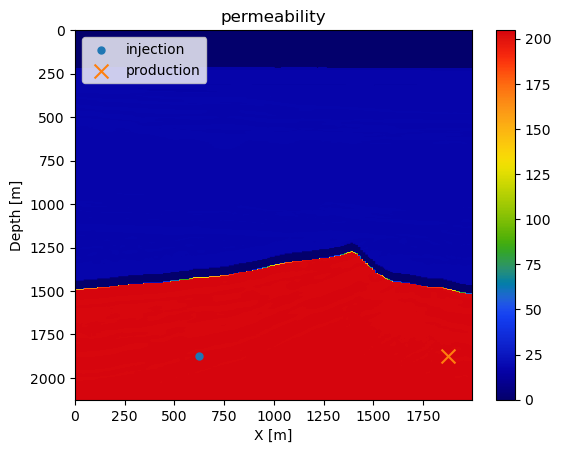

In [41]:
plot_velocity(K', d; name="permeability");colorbar();
scatter(inj_loc[1], inj_loc[2], marker=".", s=100, label="injection")
scatter(prod_loc[1], prod_loc[2], marker="x", s=100, label="production")
legend(loc=2);

Then let's do the flow simulation. This might take a while.

In [21]:
@time S, p = flow(K, ϕ, qw, qo, grid_);

570.882169 seconds (6.04 k allocations: 1006.004 MiB, 0.08% gc time, 0.00% compilation time)


Let's check some snapshots of the CO2 plume! What do you see?

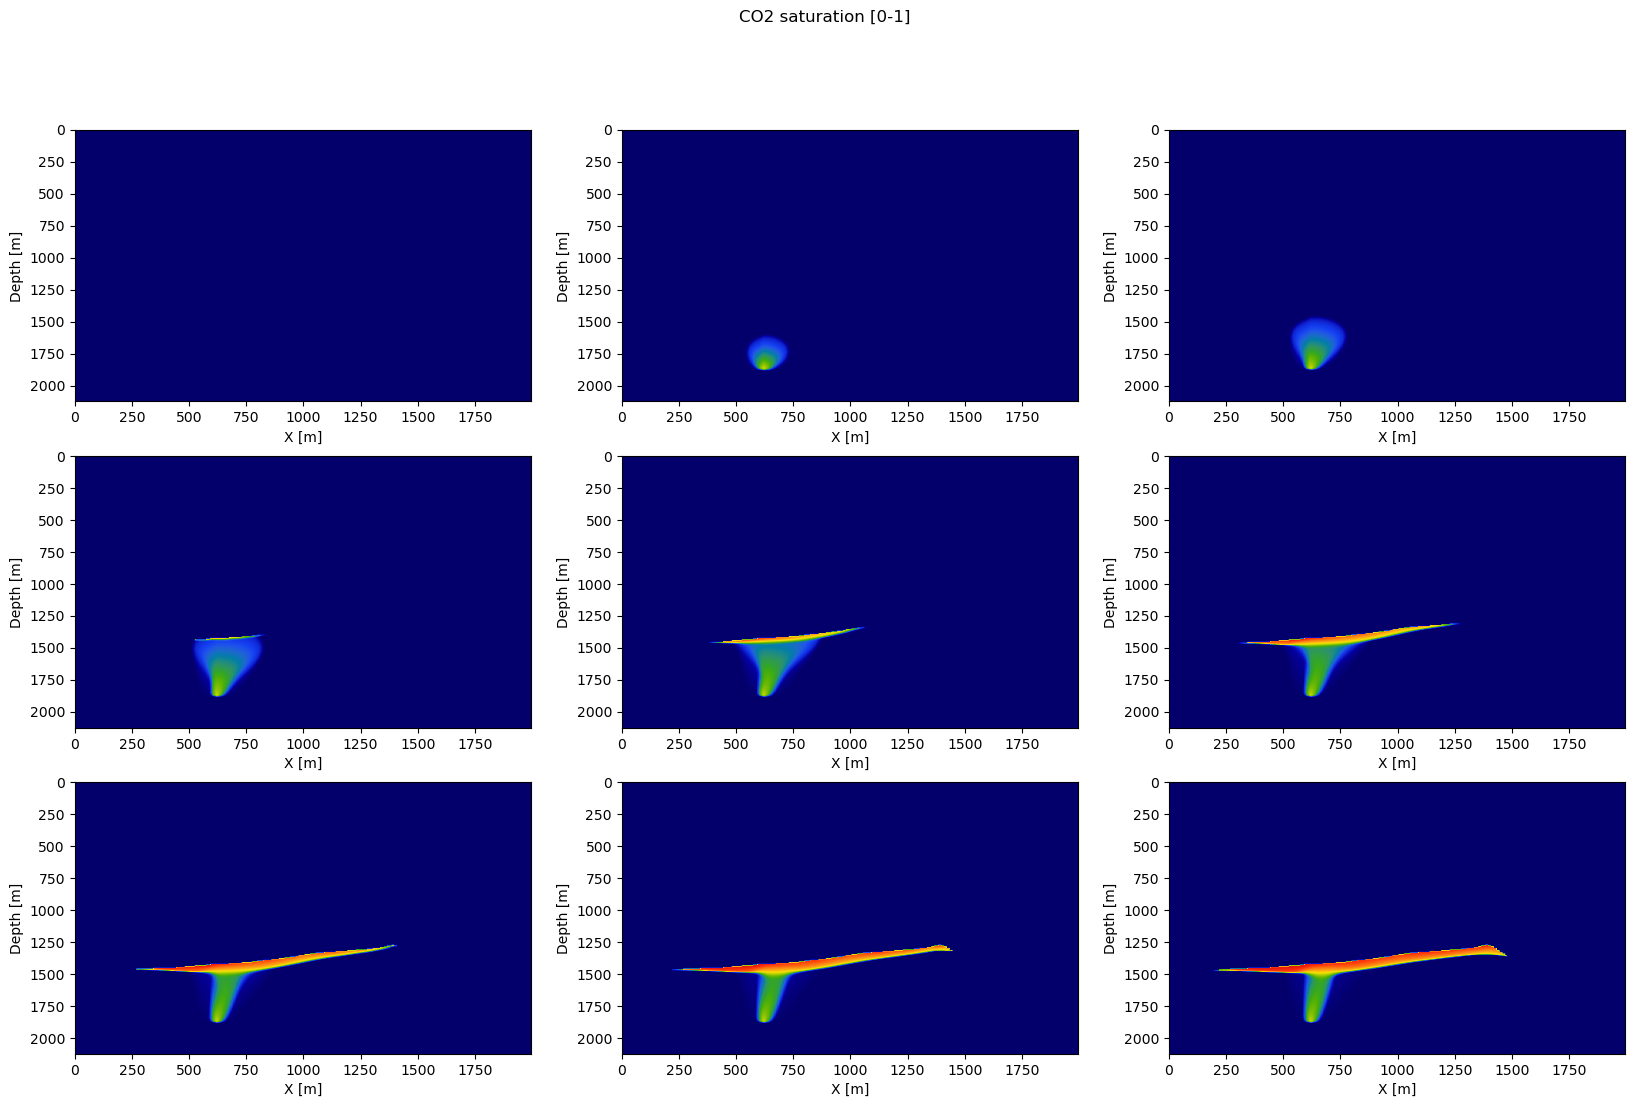

In [48]:
figure(figsize=(20,12));
obs = Int.(round.(range(1, stop=nt+1, length=9)));   # 9 observed time samples
for i = 1:9
    subplot(3,3,i)
    plot_velocity(S[obs[i],:,:]', d; name="", vmax=1, new_fig=false);
end
suptitle("CO2 saturation [0-1]");

How much CO2 did we inject to the system?

In [24]:
0.3 * nt * dt * 24 * 60 * 60

5.184e7

How much CO2 lives in the system now?

In [49]:
sum(S[end,:,:].*ϕ*d[1]*d[2]*hy)

5.1813884052539386e7

Let's save the simulation result, saturation `S` and pressure `p`, into a JLD2 file.

In [50]:
JLD2.@save "S.jld2" S p